In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import sem, entropy
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.decomposition import PCA
from my_utils import *
import pickle

from pathlib import Path
import sys
import warnings

In [2]:
import config.config as config

arg = config.ConfigGain()
arg.device = 'cpu'

In [3]:
def config_colors():
    colors = {'abort_c': '#ed2024', 'attempt_c': '#9E9F9F',
              'withvalue_c': 'lightseagreen', 'withoutvalue_c': 'salmon', 'holistic_c': 'blue',
              'RNN_c': '#faaf3b'}
    return colors

In [4]:
plt.rcParams['pdf.fonttype'] = '42'
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['mathtext.default'] = 'it'
plt.rcParams['mathtext.fontset'] = 'custom'

In [5]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

In [6]:
# agents checkpoints path
actorvalue_agents_path = Path('D:/quitting_data/agents/ActorCritic')
actornovalue_agents_path = Path('D:/quitting_data/agents/Actor_novalueCritic')
# figure path
figure_path = Path('C:/Users/rz31/Desktop/skipping_figure')
# data path
analysis_data_path_cur = Path('D:/quitting_data/analysis_data')
analysis_data_path = Path('D:/quitting_data/analysis_data2')

In [7]:
from Actor_novalue import Actor as Actor_novalue
from Actor import Actor
from Critic import Critic

# Run agent

In [8]:
from Agent_LSTM import *
from Environment import Env

In [9]:
reset_seeds(0)
env = Env(arg)
target_positions = []

for _ in range(2000):
    __ = env.reset()
    target_positions.append(env.target_position)

In [10]:
def LSTM_agent_simulation(agent):
    reset_seeds(0)
    env = Env(arg)

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []
    skipped = []

    for target_position in target_positions:
        cross_start_threshold = False
        x = env.reset(target_position=target_position)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1),
                           torch.zeros(1, 1, 1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1),
                                    torch.ones(1, 1, 1) * (t + 1)
                                   ], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            
            if is_stop and cross_start_threshold:
                break
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))

        state_.append(torch.cat(states))
        
        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())

        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        skipped.append(pos_r_end[-1] < target_r[-1] * 0.3)
        
        steps.append(np.arange(relative_r.size))

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, state=state_, action=action_,
                                 skipped=skipped))

In [11]:
agent_types = ['no_freeze', 'freeze_RNN', 'freeze_actor']
seeds = [0,1,2,5,6,7,13,14,17,18]
seeds_novalue = [1,3,4,8,11,12,15,18,19,20,21]

In [ ]:
# run data
'''
actorvalue_cur_data = []; actornovalue_cur_data = []
epi_template = np.arange(99, int(1e4), 100)
for seed in seeds:
    actorvalue_agent = Agent(arg, Actor, Critic)
    actorvalue_agent.data_path = actorvalue_agents_path / f'seed{seed}' / 'no_freeze'
    
    epi_num_episodic = len(list((actorvalue_agents_path / f'seed{seed}' / 'episodic').glob('*.tar')))
    epi_idx = epi_template.size - epi_num_episodic + 4 - 1
    epi = epi_template[epi_idx]
    
    actorvalue_agent.load(list((actorvalue_agents_path / f'seed{seed}' / 'no_freeze').glob('*.csv'))[0].stem + f'-{epi}', 
                          load_memory=False, load_optimzer=False)
    df = LSTM_agent_simulation(actorvalue_agent)
    actorvalue_cur_data.append(df)
    
for seed in seeds_novalue:
    actornovalue_agent = Agent(arg, Actor_novalue, Critic)
    actornovalue_agent.data_path = actornovalue_agents_path / f'seed{seed}' / 'no_freeze'
    
    epi_num_episodic = len(list((actornovalue_agents_path / f'seed{seed}' / 'episodic').glob('*.tar')))
    epi_idx = epi_template.size - epi_num_episodic + 4 - 1
    epi = epi_template[epi_idx]
    
    actornovalue_agent.load(list((actornovalue_agents_path / f'seed{seed}'
                                  / 'no_freeze').glob('*.csv'))[0].stem + f'-{epi}', 
                            load_memory=False, load_optimzer=False)
    df = LSTM_agent_simulation(actornovalue_agent)
    actornovalue_cur_data.append(df)
'''

In [ ]:
# save data
'''
with open(analysis_data_path_cur / 'actorvalue_cur_data.pkl', 'wb') as file:
    pickle.dump(actorvalue_cur_data, file)
    
with open(analysis_data_path_cur / 'actornovalue_cur_data.pkl', 'wb') as file:
    pickle.dump(actornovalue_cur_data, file)
'''

In [12]:
no_freeze_training_progess = []; freeze_RNN_training_progess = []; freeze_actor_training_progess = []
no_freeze_novalue_training_progess = []

for seed in seeds:
    no_freeze_training_progess.append(pd.read_csv(list((
                            actorvalue_agents_path / f'seed{seed}' / agent_types[0]).glob('*.csv'))[0]))
    freeze_RNN_training_progess.append(pd.read_csv(list((
                            actorvalue_agents_path / f'seed{seed}' / agent_types[1]).glob('*.csv'))[0]))
    freeze_actor_training_progess.append(pd.read_csv(list((
                            actorvalue_agents_path / f'seed{seed}' / agent_types[2]).glob('*.csv'))[0]))
    
for seed in seeds_novalue:
    no_freeze_novalue_training_progess.append(pd.read_csv(list((
                            actornovalue_agents_path / f'seed{seed}' / agent_types[0]).glob('*.csv'))[0]))
    
no_freeze_reward_rate = np.array([v.reward_rate.values for v in no_freeze_training_progess])
freeze_RNN_reward_rate = np.array([v.reward_rate.values for v in freeze_RNN_training_progess])
freeze_actor_reward_rate = np.array([v.reward_rate.values for v in freeze_actor_training_progess])
novalue_reward_rate = np.array([v.reward_rate.values for v in no_freeze_novalue_training_progess])

no_freeze_skip_frac = np.array([v['skipped fraction'].values for v in no_freeze_training_progess])
freeze_RNN_skip_frac = np.array([v['skipped fraction'].values for v in freeze_RNN_training_progess])
freeze_actor_skip_frac = np.array([v['skipped fraction'].values for v in freeze_actor_training_progess])
novalue_skip_frac = np.array([v['skipped fraction'].values for v in no_freeze_novalue_training_progess])

In [13]:
mean_reward_rate = [no_freeze_reward_rate.mean(axis=0), freeze_RNN_reward_rate.mean(axis=0), 
                    freeze_actor_reward_rate.mean(axis=0)]
sem_reward_rate = [sem(no_freeze_reward_rate, axis=0), sem(freeze_RNN_reward_rate, axis=0), 
                   sem(freeze_actor_reward_rate, axis=0)]
mean_skip_frac = [no_freeze_skip_frac.mean(axis=0), freeze_RNN_skip_frac.mean(axis=0), freeze_actor_skip_frac.mean(axis=0)]
sem_skip_frac = [sem(no_freeze_skip_frac, axis=0), sem(freeze_RNN_skip_frac, axis=0), sem(freeze_actor_skip_frac, axis=0)]

## 3I

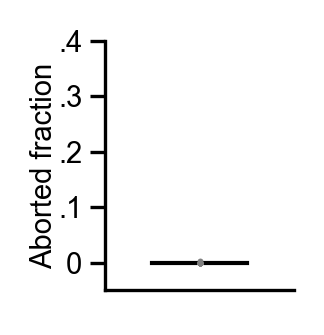

In [14]:
width = 1; height = 1

yticks = np.around(np.linspace(0, 0.4, 5), 1)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Aborted fraction', fontsize=fontsize)
ax.set_xlim(-1, 1)
ax.set_ylim(yticks[0] - 0.05, yticks[-1])
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = no_freeze_skip_frac[:, 0]
ax.plot([-0.5, 0.5], [data.mean()] * 2, lw=lw, c='k', zorder=-1)
ax.scatter([0] * data.size, data, s=2, c='gray', lw=0)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='abort_frac_phaseI'), orientation='portrait', format='pdf', transparent=True)

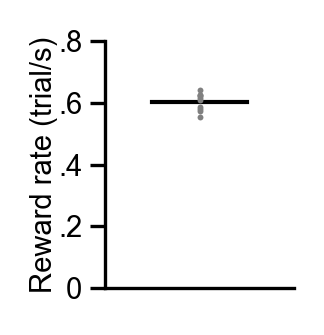

In [15]:
width = 1; height = 1

yticks = np.around(np.linspace(0, 0.8, 5), 1)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize)
ax.set_xlim(-1, 1)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = no_freeze_reward_rate[:, 0]
ax.plot([-0.5, 0.5], [data.mean()] * 2, lw=lw, c='k', zorder=-1)
ax.scatter([0] * data.size, data, s=2, c='gray', lw=0)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='reward_rate_phaseI'), orientation='portrait', format='pdf', transparent=True)

## 3J

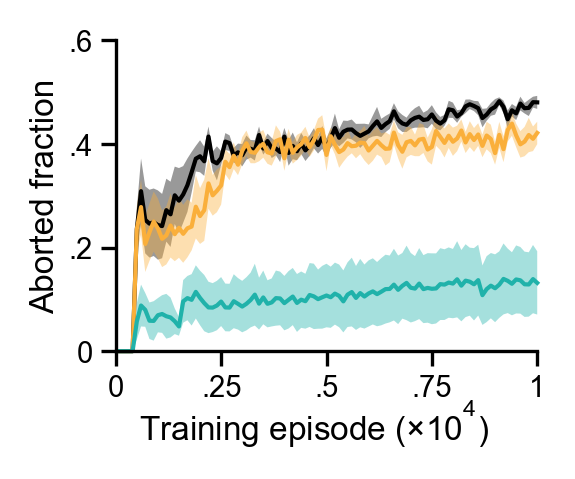

In [16]:
width = 1.8; height = 1.5
MAX_TRAINING_T = 10000

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.6, 4), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Training episode ($\times$10$^4$)', fontsize=fontsize + 1)
ax.set_ylabel('Aborted fraction', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.47, -0.15)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = no_freeze_training_progess[0].episode.values
for ymean, ysem, color in zip(mean_skip_frac, sem_skip_frac,
                                     ['k', RNN_c, withvalue_c]):
    ax.plot(xdata, ymean, lw=lw, clip_on=False, c=color)
    ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                    edgecolor='None', facecolor=color, alpha=0.4, clip_on=False)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='skip_frac_training_freeze'), orientation='portrait', format='pdf', transparent=True)

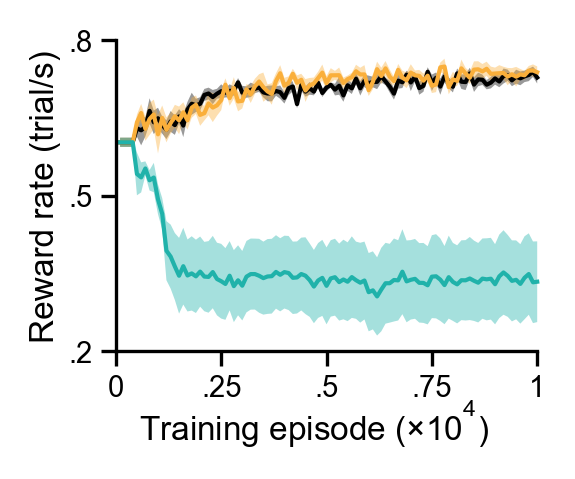

In [17]:
width = 1.8; height = 1.5
MAX_TRAINING_T = 10000

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0.2, 0.8, 3), 1)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Training episode ($\times$10$^4$)', fontsize=fontsize + 1)
ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.47, -0.15)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = no_freeze_training_progess[0].episode.values
for ymean, ysem, color, label in zip(mean_reward_rate, sem_reward_rate,
                                     ['k', RNN_c, withvalue_c], 
                                     [' '.join([vv.capitalize() if i == 0 else vv
                                                for i, vv in enumerate(v.split('_'))]) for v in agent_types] + ['']):
    ax.plot(xdata, ymean, lw=lw, clip_on=False, c=color, label=label)
    ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                    edgecolor='None', facecolor=color, alpha=0.4, clip_on=False)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='reward_rate_training_freeze'), orientation='portrait', format='pdf', transparent=True)